# Import packages and set settings

In [2]:
%load_ext autoreload
%autoreload 2

import sys
# sys.path.insert(1, './python_mods/')
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp 
import model
import saving

In [3]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import os
import collections

In [4]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Functions

In [5]:
# def get_sim_data(folder, num_sims=None):
#     try:
#         my_abs_path = os.path.exists(folder)
#     except FileNotFoundError:
#         print("Folder not found ¯\_(ツ)_/¯")
#     else:
#         all_mses = []
#         all_params = []
#         empty_data = 0
#         for i, loaded_data in enumerate(pathlib.Path(folder).glob('*.pickled')):
#             if os.path.getsize(loaded_data) > 0:
#                 with open(loaded_data, 'rb') as f:
#                     new_data = pickle.load(f)
#                     all_mses.append(np.asarray(new_data[0]))
#                     all_params.append(np.asarray(new_data[1]))
#             else:
#                 empty_data += 1
#             if num_sims:
#                 if i > num_sims:
#                     break
#     print("Number of runs collected: " + str(len(all_params)))

#     last_mses = [all_mses[i][len(all_mses[0])-1] for i in range(len(all_mses))]
#     last_params = [all_params[i][len(all_params[0])-1] for i in range(len(all_params))]

#     last_mses = np.array(last_mses)
#     last_params = np.array(last_params)
#     all_mses = np.array(all_mses)
#     all_params = np.array(all_params)

#     print('Best last gen MSE: ' + str(np.sort(last_mses)[0]))
#     print('Mean last gen MSEs of top 5%: ' + str(np.mean(np.sort(last_mses)[:round(len(last_mses)*0.05)])))
#     return all_params, last_params, all_mses, last_mses
              
# def import_data(folder):
#     all_mses = []
#     all_params = []

#     empty_data = 0
#     for loaded_data in pathlib.Path(folder).glob('*.pickled'):
#         if os.path.getsize(loaded_data) > 0:
#             with open(loaded_data, 'rb') as f:
#                 new_data = pickle.load(f)
#                 all_mses.append(np.asarray(new_data[0]))
#                 all_params.append(np.asarray(new_data[1]))
#         else:
#             empty_data += 1
#     return all_mses, all_params

# def get_exp_data(): ##AMY <- change for yourself, return how you want your data (experimental points and time) for your scorefunction
#     t_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/WT'
#     t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/T100A'
#     pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2'
#     pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2_T100A'
#     # sho1DD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/sho1DD'
#     # ssk1D_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ssk1D'
#     hog1_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1'
#     # pbs2_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data_pbs2/MAPK activation/pulse_pbs2'
#     ptpD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ptpD'

#     mapk_time, mapk_wt_data = load_csv_data(wt_folder)
#     mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)
#     # mapk_data_t100a_long = [mapk_t100a_data[0]]
#     mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

#     mapk_time, map2k_wt_data = load_csv_data(pbs2_folder)
#     mapk_time, map2k_t100a_data = load_csv_data(pbs2_t100a_folder)
#     mapk_ramp_time, hog1_ramp_data = load_csv_data(hog1_ramp_folder)
#     mapk_time, mapk_ptpD_data = load_csv_data(ptpD_folder)
#     # mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
#     # mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
#     data = [mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, mapk_ptpD_data]
#     time = [mapk_time, mapk_time_t100a_long, mapk_ramp_time]
#     return data, time

def recalc_mses(model_fxns, EA_theta_set, exp_data, exp_time, params_constants, initials, ptpD=False):
    mses = []
    for params in EA_theta_set:
        mses.append(sum(model_supp.calc_sim_score(model_fxns, params, exp_data, exp_time, params_constants, initials, ptpD)[:18]))
    re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
    thetas = EA_theta_set[re_idx]
    mses = np.sort(mses)
    return mses, thetas

def sort_mses_thetas(mses, thetas):
    re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
    thetas = thetas[re_idx]
    return np.sort(mses), thetas

def calc_mse(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD=False):
    # Takes 
    return sum(model_supp.calc_sim_score(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD)[:18]) ##AMY (insert your own error function)

def def_schedules(sorted_mses):
    best_mse = sorted_mses[0]
    worst_mse = sorted_mses[-1]
    
#     e1 = (best_mse+worst_mse)/2 #will take longer to run
    e1 = worst_mse
    e2 = (e1+best_mse)/2
    e3 = (e2+best_mse)/2
    e4 = (e3+best_mse)/2
#     e5 = (e4+best_mse)/2
    return e1, e2, e3, e4
    
def scaled_prob_mses(mses, top=.99, bot=.01):
    # mses is SORTED 
    scale = [(top-bot)*(x-mses[0])/(mses[-1]-mses[0])+bot for x in mses]
    inv = [1/x for x in scale]
    probs = [x/sum(inv) for x in inv]
    return probs

def draw_thetas(sorted_params, probs):
    idx = np.random.choice(range(len(sorted_params)), 1, p=probs)
    return sorted_params[idx][0]

def step_theta(theta):
    log_theta = np.log10(theta) 
    theta_prime = np.concatenate([10**(np.random.uniform(x-.1,x+.1,1)) for x in log_theta], axis=0)
    return theta_prime

def run_schedule(prior_thetas, probs, ei, num_theta_primes):
    thetas_ei = []
    mses_ei = []
    c = collections.Counter({'Pass': 0, 'Fail': 0}) 
    while len(thetas_ei) < num_theta_primes:
        theta = draw_thetas(prior_thetas, probs)
        theta_prime = step_theta(theta)
        mse = calc_mse(M2_fxns, theta_prime, exp_data, exp_time, params_constants, initials, ptpD=False) ##AMY error fxn
        if mse < ei:
            c['Pass'] += 1
            thetas_ei.append(theta_prime)
            mses_ei.append(mse)
            if len(mses_ei) % int(num_theta_primes*.1) == 0:
                print(str(int(len(mses_ei)/num_theta_primes*100)) + "% complete.") 
        else:
            c['Fail'] += 1
    return np.asarray(mses_ei), np.asarray(thetas_ei), c

# Model

## Model Functions

In [16]:
from scipy.optimize import fsolve
from scipy.integrate import odeint

In [4]:
# def simulate_t100a_experiment_M2b_kb(m, inits, total_protein, sig, learned_params, time,  run_type=None):
#         beta_3, alpha, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params #17
#         learned_params = beta_3, 0, kb, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
#         #solve odes:
#         odes = odeint(m, inits, time, args=(total_protein, sig, learned_params, run_type))
#         return odes

# def simulate_nopos_experiment_M2b_kb(m, inits, total_protein, sig, learned_params, time,  run_type=None):
#     beta_3, alpha, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params #17
#     learned_params = beta_3, 0, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
#     #solve odes:
#     odes = odeint(m, inits, time, args=(total_protein, sig, learned_params, run_type))
#     return odes

# def M2b_kb(initials,t,total_protein,sig,params, run_type=None):
# #     if run_type:
# #         if run_type[0] == 'ramp':
# #             sig = signal_ramp_special(t)
# #         elif run_type[0] == 'rand':
# #             sig = get_ramp_signal(t, run_type[1])
# #         elif run_type[0] == 'man':
# #             sig = get_manual_signal(t)

#     MAP3K, MAP2K, MAPK, gly = initials
#     MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
#     beta_3, alpha, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params #17

#     MAP3K_I = MAP3K_t-MAP3K
#     MAP2K_I = MAP2K_t-MAP2K
#     MAPK_I = MAPK_t-MAPK
#     # PTP_I = PTP_t-PTP

#     dMAP3K = (((sig*k1 + kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
#     dMAP2K = (((k3*MAP3K + MAPK*alpha)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K)) #bug
#     dMAPK = (((k5)*MAP2K)*MAPK_I)/(K_5+MAPK_I) - (k6*MAPK)/(K_6+MAPK)
#     dgly = s7*MAPK - d8*gly

#     return dMAP3K, dMAP2K, dMAPK, dgly

# def run_ss(m, inits, total_protein, learned_params):
#     ss = fsolve(m, inits, args=(0,total_protein, 0, learned_params))
#     return ss

# def simulate_wt_experiment(m, inits, total_protein, sig, learned_params, time, run_type=None):
#     odes = odeint(m, inits, time, args=(total_protein, sig, learned_params, run_type))
#     return odes

# def molarity_conversion(molecules):
#     Na = 6.02214076*10**23
#     cell_volume = 44                                                                 # approx volume of a SC yeast cell
#     return molecules/(Na*cell_volume*10**-15)*1000000 

# class Model():
#     def __init__(self, m, t100a, nopos=None):
#         self.m = m
#         self.t100a = t100a
#         self.nopos = nopos
     



## Model Variables (Constants)

In [6]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)


MAP3K_t = model_supp.molarity_conversion(701)
MAP2K_t = model_supp.molarity_conversion(2282)
MAPK_t = model_supp.molarity_conversion(5984)
PTP_t = model_supp.molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on


labelnames = ['$- fb$', '$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$',
              '$k_2$', '$k_4$', '$k_6$', '$d_1$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$']


minimums = [-4, -4, 
        -4, -4, -4, -4,
        -4, -4, -4, -4, 
        -4, -4, -4, 
        -4, -4, -4]

maximums = [ 4, 4, 
        4, 4, 4, 4,
        4, 4, 4, 4, 
        4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums) #for plotting
dims = (diff, minimums) #for plotting

initials = [MAP3K, MAP2K, MAPK, gly]

params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 

doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]

# Load experimental data

In [7]:
exp_data, exp_time = model_supp.get_data()

mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, mapk_ptpD_data = exp_data
mapk_time, mapk_time_t100a_long, mapk_ramp_time = exp_time 

mapk_data_t100a_long = [mapk_t100a_data[0]] 

mapk_t100a_data = [mapk_t100a_data[0][:9]] + mapk_t100a_data[1:] #shorten for plotting



# Load simulation data

In [8]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190924_kb_M2/'

all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)

M2_fxns = model.Model(model.M2_kb, model.simulate_t100a_experiment_M2_kb)

In [21]:
## sort
M2_sorted_mses_EA, M2_sorted_thetas_EA = sort_mses_thetas(last_mses, last_params)

# Check EA results

No handles with labels found to put in legend.


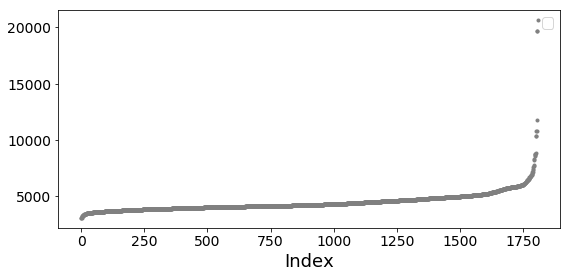

In [22]:
plotting.plt_idx_vs_mse(M2_sorted_mses_EA, len(M2_sorted_mses_EA))

No handles with labels found to put in legend.


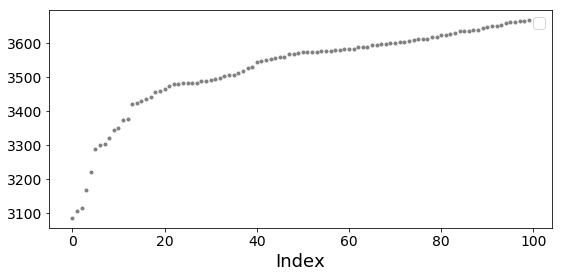

In [23]:
plotting.plt_idx_vs_mse(M2_sorted_mses_EA, 100)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

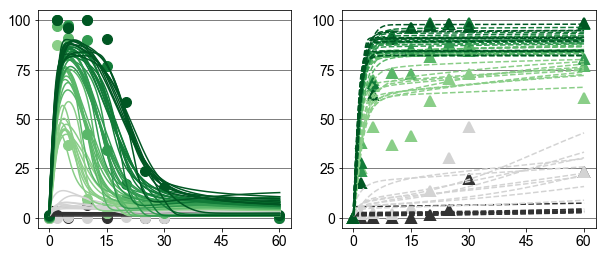

In [24]:
# original parameter values
plotting.plt_param_behaviors(M2_fxns, M2_sorted_thetas_EA, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

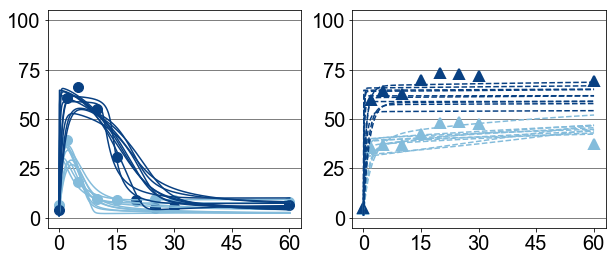

In [21]:
plotting.plt_param_behaviors(M2_fxns, M2_sorted_thetas_EA, 10, params_constants, initials,  [150000,550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

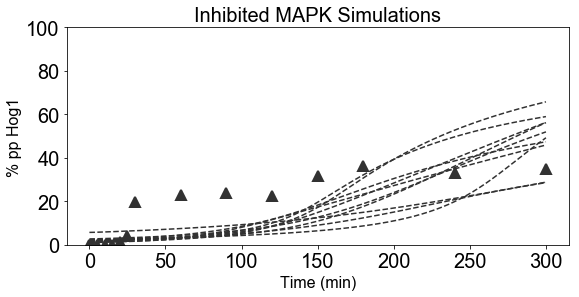

In [26]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2_fxns, M2_sorted_thetas_EA, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)

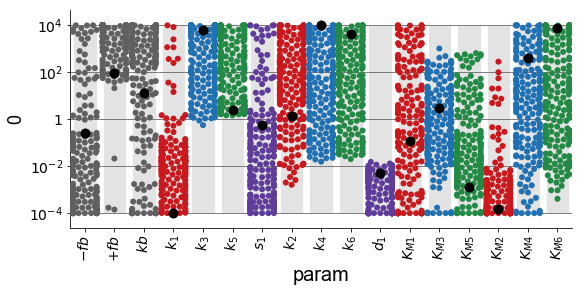

In [16]:
df_top_thetas_EA = pd.DataFrame(M2a_sorted_thetas_EA)
df_top_thetas_EA.columns = labelnames

num_plt = 200
df_plt = pd.DataFrame(M2a_sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

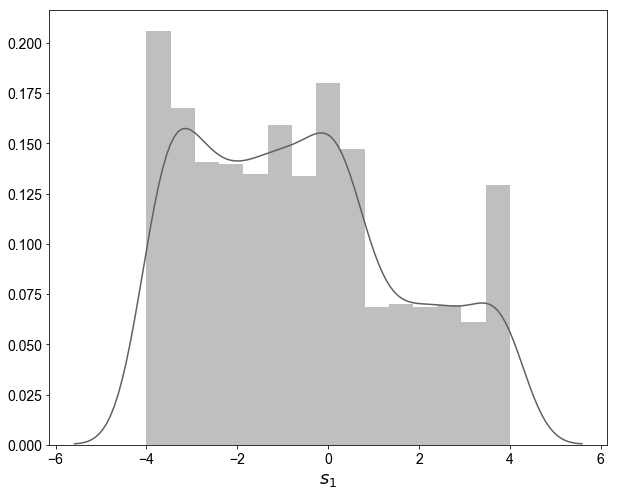

In [17]:
sns.distplot(np.log10(df_top_thetas_EA[labelnames[6]]))

In [ ]:
sims_M2c_kb_ea = plotting.simdata_to_df(M2c_fxns, M2c_sorted_thetas_EA, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


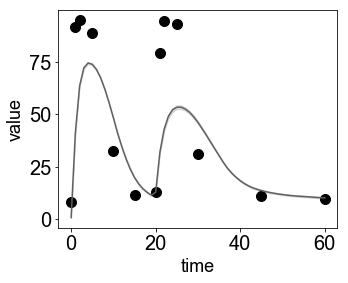

In [88]:
plotting.plt_ramp_cis(sims_M2b_kb_ea, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

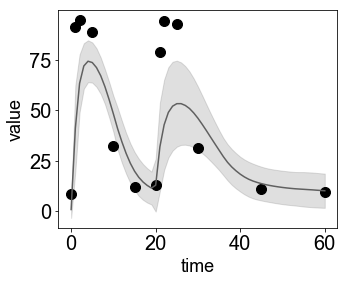

In [89]:
plotting.plt_ramp_cis(sims_M2b_kb_ea, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

In [25]:
sims = []
for params in M2a_sorted_thetas_EA:
#     if ss:
    ss_data = model.run_ss(M2a_fxns.m, initials, params_constants, params)
    data = model.simulate_wt_experiment(M2a_fxns.m, ss_data, params_constants, 0, params, time, run_type=['ramp'])
#     else:
#         data = simulate_wt_experiment(model_fxns.m, initials, params_constants, 0, params, time, run_type=['ramp'])
    active = data[:,2]/params_constants[2]*100
    sims.append(active)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


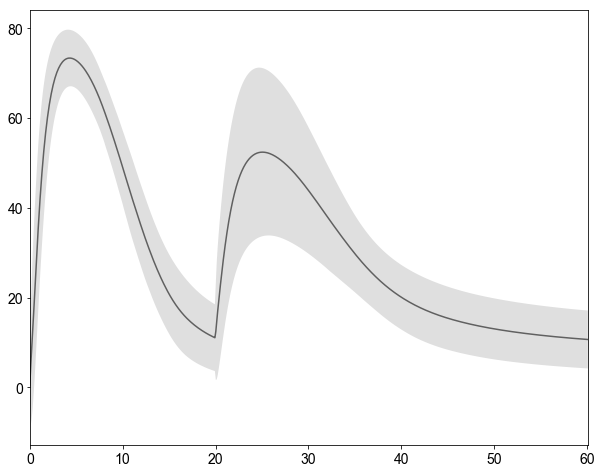

In [29]:
sns.tsplot(sims, time,  ci = "sd")


# SMC

## Try different sizes of EA 

I've been using top 500 and it's worked really well, but here I'm using top 20 so that it runs fast

In [29]:
M2_new_mses_EA, M2_new_thetas_EA = recalc_mses(M2_fxns, M2_sorted_thetas_EA, exp_data, exp_time, params_constants, initials)

print(M2_new_mses_EA[:10])

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

[2885.81913191 2985.29122384 3009.19113205 3073.74398572 3091.85821225
 3099.26505294 3115.13961531 3121.46233949 3127.23056753 3164.75876755]


In [30]:
M2_EA_thetas_1perc = M2_new_thetas_EA[:500]
M2_EA_mses_1perc = M2_new_mses_EA[:500]

## Define schedules

I've been messing around with where I start with the schedule and how many schedules to run

No handles with labels found to put in legend.


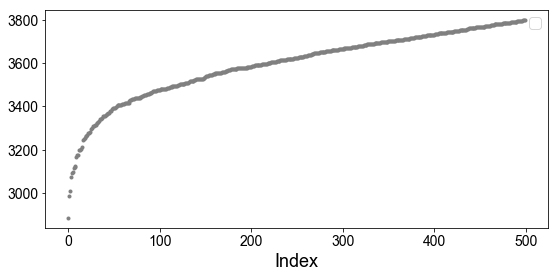

In [33]:
plotting.plt_idx_vs_mse(M2_EA_mses_1perc, len(M2_EA_mses_1perc))

In [34]:
e1, e2, e3, e4 = def_schedules(M2_EA_mses_1perc)

print("Best MSE: " + str(M2_EA_mses_1perc[0]))
print("Worst MSE: " + str(M2_EA_mses_1perc[-1]))
print()
print("Schedules: " + str(e1),str(e2),str(e3),str(e4))
print()


Best MSE: 2885.8191319079297
Worst MSE: 3797.356019084577

Schedules: 3797.356019084577 3341.5875754962535 3113.7033537020916 2999.7612428050106



## Define probability

I've also been messing around with the `top` and `bot` params of `scaled_prob_mses`. 
- (.9 and .1) 
- (.95 and .05) 
- (.99 and .01)

I've noticed that with the larger number of EA thetas, the more extreme ranges are better. 
If you start with a small number of EA thetas, being more conservative with the ranges
results in more balanced probabilities.

In [35]:
probs = scaled_prob_mses(M2_EA_mses_1perc, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])


[0.12504237369508323, 0.010692575452405484, 0.008766405038987929, 0.0058971294739081, 0.005401068813951198]
[0.0012684357778351134, 0.0012678447592729405, 0.0012645021002021036, 0.00126401931640467, 0.0012630542797483154]


## Schedule 1

I use `num_theta_primes = 1000`, but set to 100 to be faster.

In [38]:
mses_e1, thetas_e1, count_e1 = run_schedule(M2_EA_thetas_1perc, probs, e1, num_theta_primes=1000)
mses_e1_sort, thetas_e1_sort = sort_mses_thetas(mses_e1, thetas_e1)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

10% complete.


../../python_modules\model.py:268: RuntimeWarning: divide by zero encountered in double_scalars
  dMAP3K = (((sig*k1 + kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
../../python_modules\model.py:268: RuntimeWarning: invalid value encountered in double_scalars
  dMAP3K = (((sig*k1 + kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [39]:
df_top_thetas_e1 = pd.DataFrame(thetas_e1_sort)
df_top_thetas_e1.columns = labelnames

df_top_thetas_e1.to_csv('M2_kb_thetas_e1.csv')

In [ ]:
num_plt = 100
df_plt = pd.DataFrame(thetas_e1_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

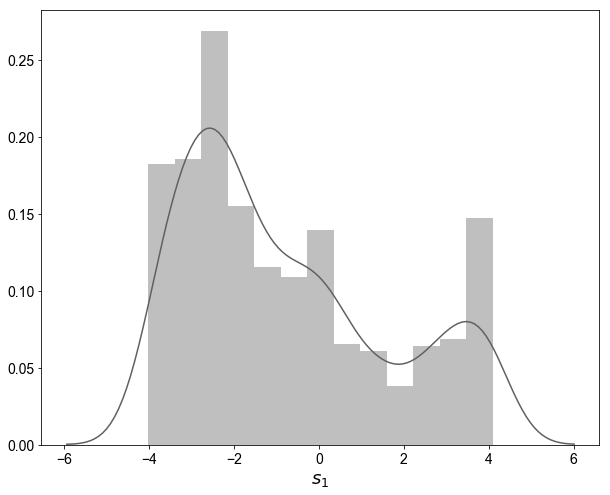

In [28]:
sns.distplot(np.log10(df_top_thetas_e1[labelnames[6]]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

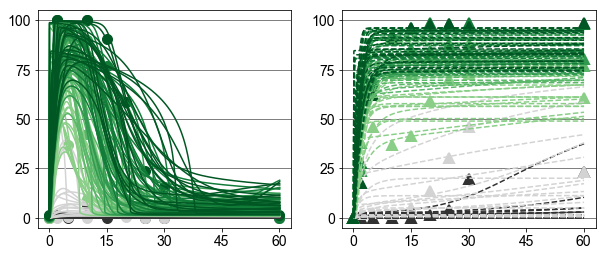

In [29]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e1, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

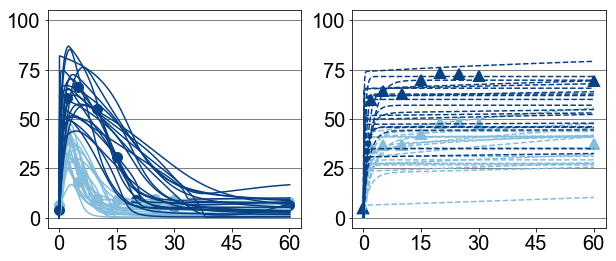

In [30]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e1, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [ ]:
sims_M2b_kb_e1 = plotting.simdata_to_df(M2b_fxns, thetas_e1_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.


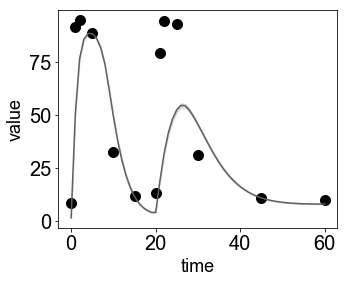

In [83]:
plotting.plt_ramp_cis(sims_M2b_kb_e1, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

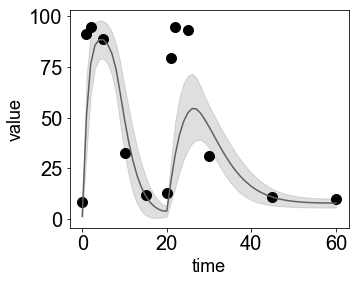

In [81]:
plotting.plt_ramp_cis(sims_M2b_kb_e1, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

## Schedule 2

Redefine probs based on results of last schedule.

In [40]:
probs = scaled_prob_mses(mses_e1_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.05868816598628044, 0.011307383829016762, 0.009866543224481324, 0.009601645937671311, 0.008182548137554771]
[0.0005929384272224208, 0.0005929162802078969, 0.0005928945133757011, 0.0005928135204356681, 0.0005928097574371762]


In [41]:
mses_e2, thetas_e2, count_e2 = run_schedule(thetas_e1_sort, probs, e2, num_theta_primes=1000)
mses_e2_sort, thetas_e2_sort = sort_mses_thetas(mses_e2, thetas_e2)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\o

10% complete.
20% complete.
30% complete.
40% complete.
50% complete.


../../python_modules\model.py:268: RuntimeWarning: invalid value encountered in double_scalars
  dMAP3K = (((sig*k1 + kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))


60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [42]:
df_top_thetas_e2 = pd.DataFrame(thetas_e2_sort)
df_top_thetas_e2.columns = labelnames

df_top_thetas_e2.to_csv('M2_kb_thetas_e2.csv')

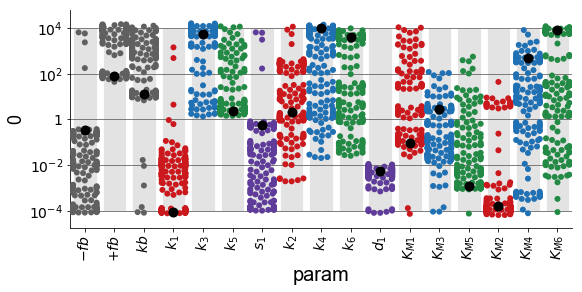

In [43]:
num_plt = 200
df_plt = pd.DataFrame(thetas_e2_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

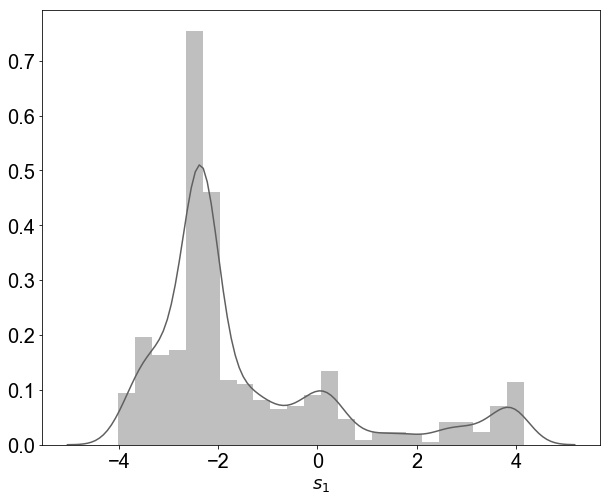

In [36]:
sns.distplot(np.log10(df_top_thetas_e2[labelnames[6]]))

<Figure size 720x576 with 0 Axes>

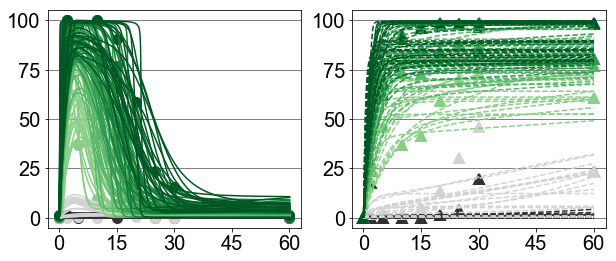

In [37]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

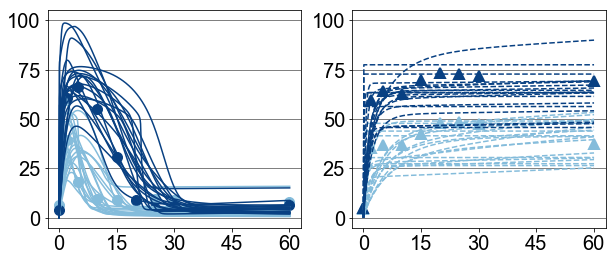

In [38]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [84]:
sims_M2b_kb_e2 = plotting.simdata_to_df(M2b_fxns, thetas_e2_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


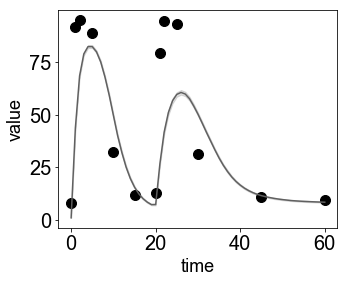

In [85]:
plotting.plt_ramp_cis(sims_M2b_kb_e2, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

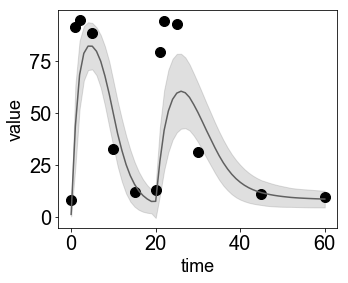

In [86]:
plotting.plt_ramp_cis(sims_M2b_kb_e2, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

### Investigating modality

PCA to see if modality can be explained by theta variance. Also, see if better scores are clustering together.

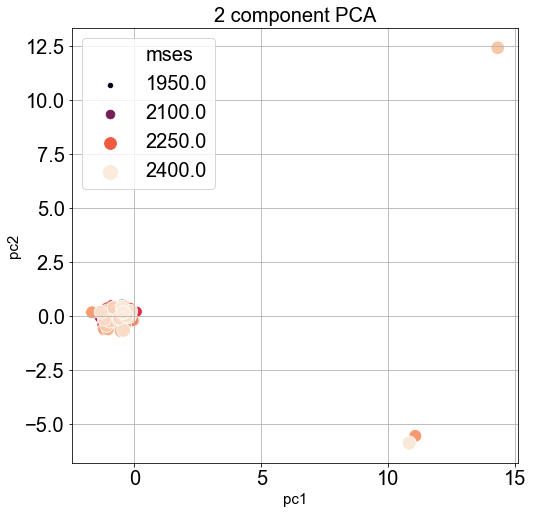

In [310]:
from sklearn.preprocessing import StandardScaler

df_top_thetas_e2_log = df_top_thetas_e2.apply(np.log10)

df_top_thetas_e2_log['mses'] = mses_e2_sort

x = df_top_thetas_e2_log.loc[:, labelnames].values
y = df_top_thetas_e2_log.loc[:,['mses']].values
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

finalDf = pd.concat([principalDf, df_top_thetas_e2_log[['mses']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

sns.scatterplot(x='pc1', y='pc2', hue='mses', size='mses',sizes=(20, 200), data=finalDf[finalDf['mses']<2400], palette="rocket")

ax.grid()

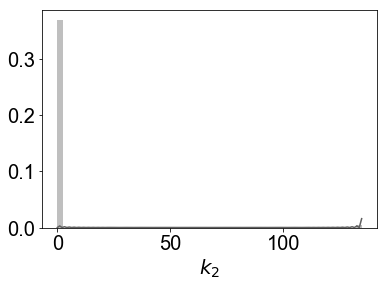

In [311]:
df_top_params_e2 = pd.DataFrame(thetas_e2)
df_top_params_e2.columns = labelnames
sns.distplot(df_top_params_e2[labelnames[7]])

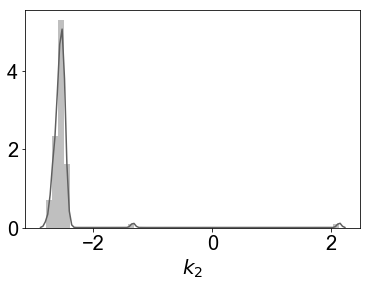

In [312]:
sns.distplot(np.log10(df_top_params_e2[labelnames[7]]))

<Figure size 432x288 with 0 Axes>

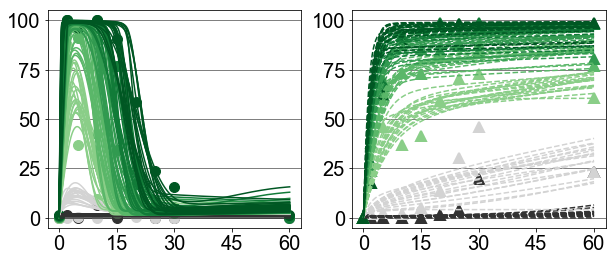

In [314]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 432x288 with 0 Axes>

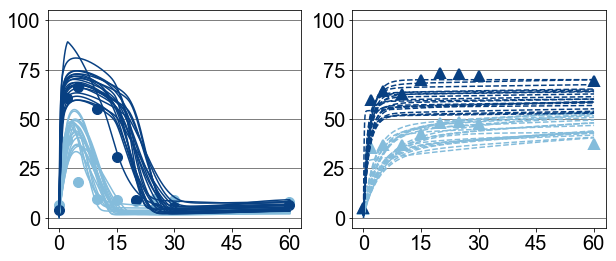

In [315]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

## Schedule 3 

In [43]:
probs = scaled_prob_mses(mses_e2_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.05395399936244782, 0.03733983555274291, 0.013964350542073567, 0.009443477633783197, 0.00900004589502563]
[0.0005472488433572106, 0.0005464677925930962, 0.0005461270259773429, 0.0005457268462475809, 0.000544989892549978]


In [44]:
mses_e3, thetas_e3, count_e3 = run_schedule(thetas_e2_sort, probs, e3, num_theta_primes=1000)
mses_e3_sort, thetas_e3_sort = sort_mses_thetas(mses_e3, thetas_e3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\o

10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [48]:
df_top_thetas_e3 = pd.DataFrame(thetas_e3_sort)
df_top_thetas_e3.columns = labelnames

df_top_thetas_e3.to_csv('M2_kb_thetas_e3.csv')

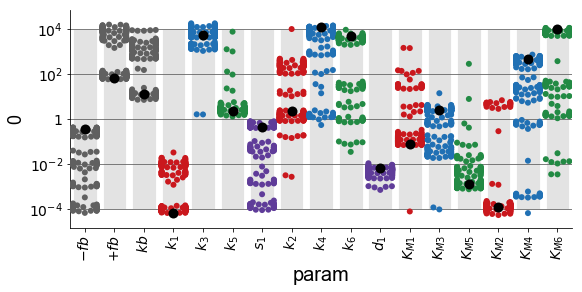

In [47]:
num_plt = 250
df_plt = pd.DataFrame(thetas_e3_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

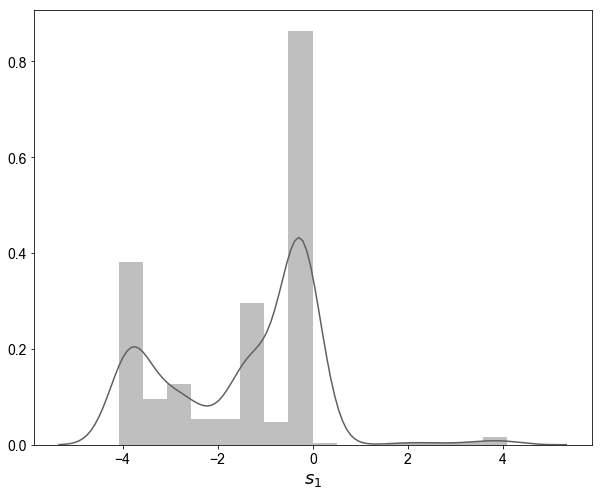

In [48]:
sns.distplot(np.log10(df_top_thetas_e3[labelnames[6]]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

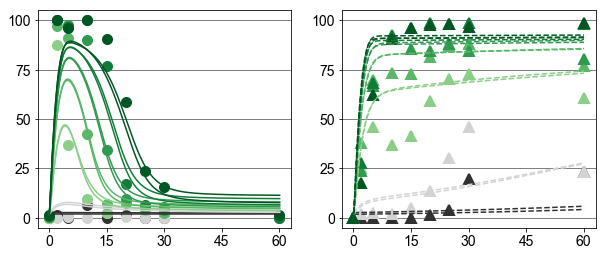

In [45]:
plotting.plt_param_behaviors(M2_fxns, thetas_e3_sort, 2, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

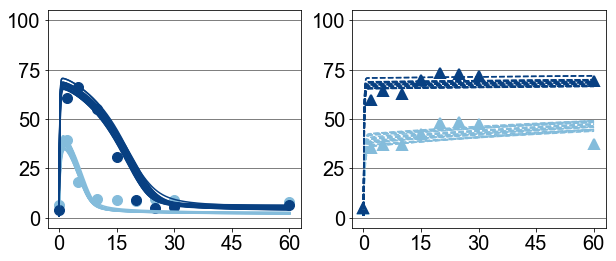

In [46]:
plotting.plt_param_behaviors(M2_fxns, thetas_e3_sort, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [51]:
sims_M2a_kb_e3 = plotting.simdata_to_list(M2a_fxns, thetas_e3_sort, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


10% complete.
20% complete.
30% complete.
40% complete.
50% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


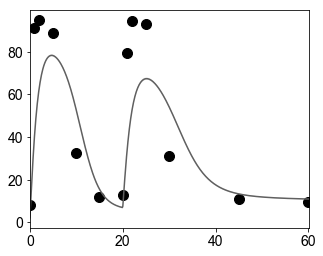

In [52]:
plotting.plt_ramp_cis(sims_M2a_kb_e3, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


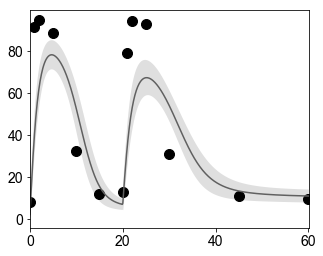

In [54]:
plotting.plt_ramp_cis(sims_M2a_kb_e3, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

## Schedule 4

In [49]:
probs = scaled_prob_mses(mses_e3_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.05265793370687017, 0.018069327676715964, 0.015655752815384383, 0.010012806855304136, 0.0056529965662078215]
[0.0005324924669295602, 0.0005323464218892401, 0.0005321329771419337, 0.0005319073086350565, 0.0005318983202714159]


In [50]:
mses_e4_M2_kb, thetas_e4_M2_kb, count_e4_M2_kb = run_schedule(thetas_e3_sort, probs, e4, num_theta_primes=1000)


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\o

10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


NameError: name 'mses_e4_M2b_kb' is not defined

In [51]:
mses_e4_sort_M2_kb, thetas_e4_sort_M2_kb = sort_mses_thetas(mses_e4_M2_kb, thetas_e4_M2_kb)

In [52]:
df_top_thetas_e4_m2_kb = pd.DataFrame(thetas_e4_sort_M2_kb)
df_top_thetas_e4_m2_kb.columns = labelnames
df_top_thetas_e4_m2_kb.to_csv('M2_kb_thetas_e4.csv')

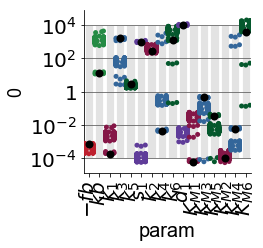

In [55]:
num_plt = 1000
df_plt = pd.DataFrame(df_top_thetas_e4_m2_kb[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

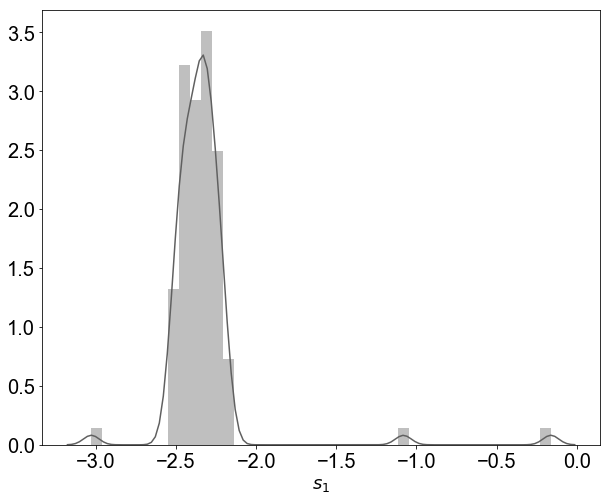

In [64]:
sns.distplot(np.log10(df_top_thetas_e4_m2b_kb[labelnames[6]]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

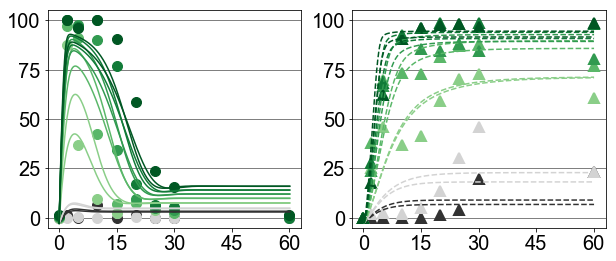

In [73]:
plotting.plt_param_behaviors(M2_fxns, thetas_e4_sort_M2_kb, 2, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

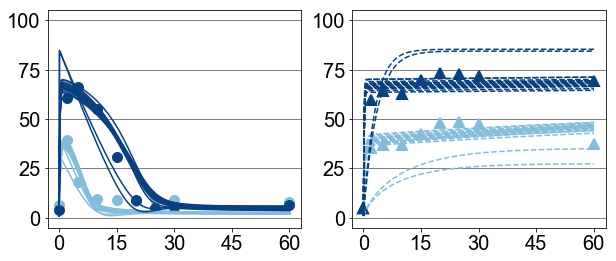

In [76]:
plotting.plt_param_behaviors(M2_fxns, thetas_e4_sort_M2_kb, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

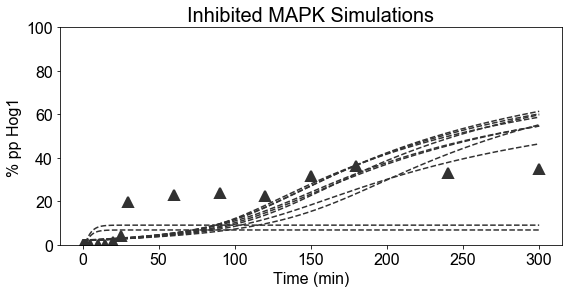

In [69]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2_fxns, thetas_e4_sort_M2_kb, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 50000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 250000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 450000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

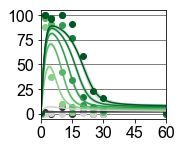

In [68]:
plotting.plt_param_cis(M2_fxns, thetas_e4_sort_M2_kb, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

In [1]:
plotting.plt_param_cis(M2_fxns, thetas_e4_sort_M2_kb, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_data_t100a, exp_time=mapk_time_t100a, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

NameError: name 'plotting' is not defined

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

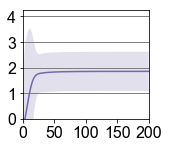

In [66]:
time_long = np.linspace(0,dt*2001,steps)

plotting.plt_param_cis(M2_fxns, thetas_e4_sort_M2_kb, params_constants, initials,  [350000], time_long, 3,
                        exp_data=None, exp_time=None, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='M2_X.pdf')

## Plotting error on simulations

Tim said to compare bootstrapping the final distribution of thetas and just plotting all of the resulting simulations of that final distribution of thetas. Here I've just done the latter for just WT Hog1 at 550!

In [124]:
colnames = ['idx', 'time', 'value']
sims = pd.DataFrame(columns = colnames)
for idx, params in enumerate(thetas_e3_sort):
        ss_data = model.run_ss(M2b_fxns.m, initials, params_constants, params)
        data = model.simulate_wt_experiment(M2b_fxns.m, ss_data, params_constants, 550000, params, time)
        active = data[:,2]/params_constants[2]*100
        for t, point in enumerate(active):
            sims = sims.append({'idx': idx, 'time': t/10, 'value': point}, ignore_index=True)

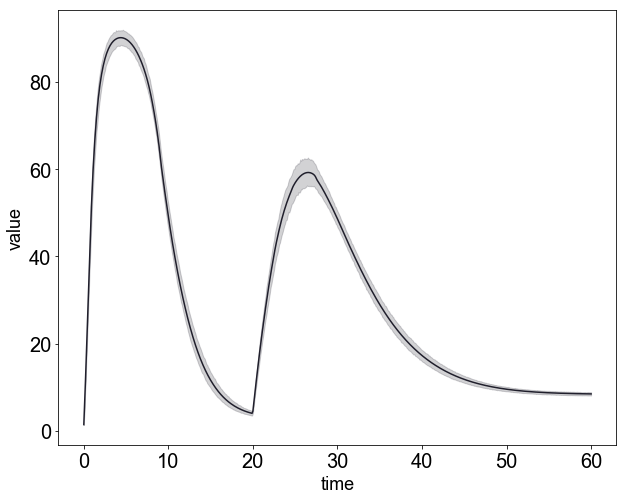

In [132]:
plotting.plt_ramp_cis(M2b_fxns, thetas_e3_sort, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

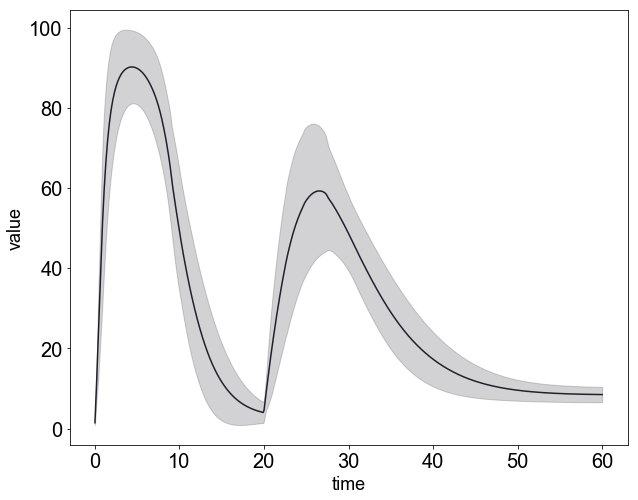

In [133]:
plotting.plt_ramp_cis(M2b_fxns, thetas_e3_sort, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci = 'sd')

In [ ]:
plotting.plt_param_cis(M2c_fxns, thetas_e4_sort_M2b_kb[:707], params_constants, initials,  [350000], time_long, 3,
                        exp_data=None, exp_time=None, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig=folder_base+'31')

# Checking fits!

In [9]:
theta_file = 'M2_kb_thetas_e4.csv'
thetas_e4_sort = np.array(pd.read_csv(theta_file).drop(['Unnamed: 0'], axis=1))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

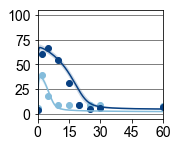

In [11]:
plotting.plt_param_cis(M2_fxns, thetas_e4_sort, params_constants, initials,  [150000,550000], time, 1,
                        exp_data=map2k_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

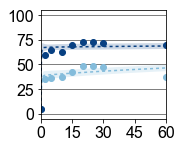

In [13]:
plotting.plt_param_cis(M2_fxns, thetas_e4_sort, params_constants, initials,  [150000,550000], time, 1,
                        exp_data=map2k_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 50000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 250000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 450000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

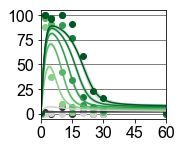

In [14]:
plotting.plt_param_cis(M2_fxns, thetas_e4_sort, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 50000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 250000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 450000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

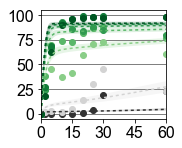

In [15]:
plotting.plt_param_cis(M2_fxns, thetas_e4_sort, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

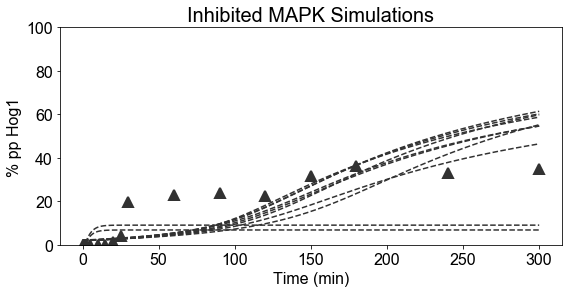

In [16]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2_fxns, thetas_e4_sort, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)

In [17]:
time_long = np.linspace(0,dt*2001,steps)


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

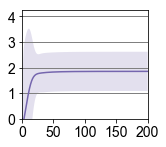

In [18]:
plotting.plt_param_cis(M2_fxns, thetas_e4_sort, params_constants, initials,  [350000], time_long, 3,
                        exp_data=None, exp_time=None, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

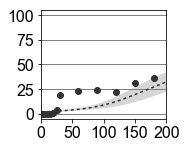

In [19]:
plotting.plt_param_cis(M2_fxns, thetas_e4_sort, params_constants, initials,  [0], time, 2,
                        exp_data=mapk_data_t100a_long, exp_time=mapk_time_t100a_long, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')